In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import root_mean_squared_error
import os
from dotenv import load_dotenv



In [3]:
df=pd.read_csv('dataset\zomato.csv')

In [4]:
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-23,116.000000,138.899994,115.000000,126.000000,126.000000,694895290
1,2021-07-26,126.349998,143.750000,125.300003,140.649994,140.649994,249723854
2,2021-07-27,141.699997,147.800003,127.750000,132.899994,132.899994,240341900
3,2021-07-28,131.000000,135.000000,123.550003,131.199997,131.199997,159793731
4,2021-07-29,134.949997,144.000000,132.199997,141.550003,141.550003,117973089


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
626,2024-02-01,141.000000,143.500000,138.550003,140.550003,140.550003,70252449
627,2024-02-02,141.800003,145.000000,141.449997,143.800003,143.800003,78666454
628,2024-02-05,145.000000,145.399994,138.250000,140.250000,140.250000,54189688
629,2024-02-06,140.399994,141.800003,138.050003,139.949997,139.949997,46782951
630,2024-02-07,141.000000,142.899994,139.649994,140.399994,140.399994,75083259


In [6]:
close_df=df.reset_index()['Close']
close_df

0      126.000000
1      140.649994
2      132.899994
3      131.199997
4      141.550003
          ...    
626    140.550003
627    143.800003
628    140.250000
629    139.949997
630    140.399994
Name: Close, Length: 631, dtype: float64

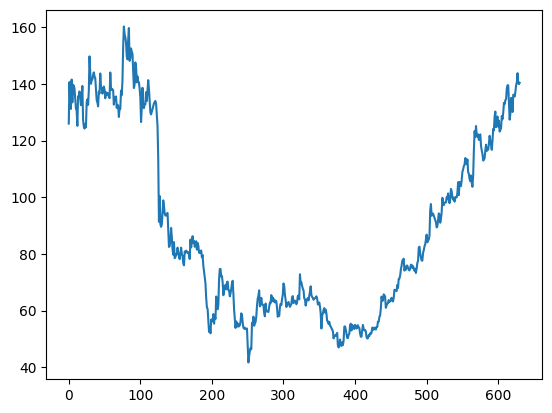

In [7]:
plt.plot(close_df)

In [10]:
###LSTM are sensitive to the scale of data, so we apply min max scaler to bring the values between 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
close_df=scaler.fit_transform(np.array(close_df).reshape(-1,1))

In [11]:
close_df

array([[0.71091443],
       [0.83438678],
       [0.76906862],
       [0.75474079],
       [0.84197219],
       [0.77412556],
       [0.82638006],
       [0.82385159],
       [0.81542344],
       [0.78634635],
       [0.75600508],
       [0.74968397],
       [0.70417189],
       [0.79224603],
       [0.79056042],
       [0.80657398],
       [0.78634635],
       [0.76569741],
       [0.78634635],
       [0.82300885],
       [0.72144962],
       [0.70248628],
       [0.69616517],
       [0.70965019],
       [0.69995781],
       [0.77454699],
       [0.78297514],
       [0.76654027],
       [0.80868102],
       [0.91108299],
       [0.86304256],
       [0.82932996],
       [0.83944372],
       [0.84239362],
       [0.85545715],
       [0.863464  ],
       [0.85124308],
       [0.84618626],
       [0.81120937],
       [0.7808681 ],
       [0.77370412],
       [0.7623262 ],
       [0.80615255],
       [0.80067418],
       [0.86009266],
       [0.82048038],
       [0.81626631],
       [0.800

In [12]:
#splitting dataset into train test split
training_size=int(len(close_df)*0.65)
test_size=len(close_df)-training_size
train_data, test_data= close_df[0:training_size,:], close_df[training_size:len(close_df),:1]

In [13]:
training_size,test_size

(410, 221)

In [14]:
train_data

array([[0.71091443],
       [0.83438678],
       [0.76906862],
       [0.75474079],
       [0.84197219],
       [0.77412556],
       [0.82638006],
       [0.82385159],
       [0.81542344],
       [0.78634635],
       [0.75600508],
       [0.74968397],
       [0.70417189],
       [0.79224603],
       [0.79056042],
       [0.80657398],
       [0.78634635],
       [0.76569741],
       [0.78634635],
       [0.82300885],
       [0.72144962],
       [0.70248628],
       [0.69616517],
       [0.70965019],
       [0.69995781],
       [0.77454699],
       [0.78297514],
       [0.76654027],
       [0.80868102],
       [0.91108299],
       [0.86304256],
       [0.82932996],
       [0.83944372],
       [0.84239362],
       [0.85545715],
       [0.863464  ],
       [0.85124308],
       [0.84618626],
       [0.81120937],
       [0.7808681 ],
       [0.77370412],
       [0.7623262 ],
       [0.80615255],
       [0.80067418],
       [0.86009266],
       [0.82048038],
       [0.81626631],
       [0.800

In [15]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset,time_step=1):
    dataX, dataY= [],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX),np.array(dataY)

In [17]:
# reshape into X=t, t+1,t+2, t+3 and Y=t+4

time_step=100
X_train, y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [18]:
X_train.shape, y_train.shape

((309, 100), (309,))

In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train= X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [24]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\satya\OneDrive\Desktop\Zomato_price_prediction-1\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=100, batch_size=64,verbose=1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0560 - val_loss: 0.0018
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0161 - val_loss: 0.0526
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0083 - val_loss: 0.0494
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0052 - val_loss: 0.0229
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0044 - val_loss: 0.0239
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0042 - val_loss: 0.0100
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0037 - val_loss: 0.0166
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0039 - val_loss: 0.0188
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0038 - val_loss: 0.0115
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0032 - val_loss: 0.0168
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0041 - val_l

In [26]:
# prdiction and checking performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [27]:
train_predict, test_predict

(array([[0.7515981 ],
        [0.75919855],
        [0.75445795],
        [0.7481572 ],
        [0.7505993 ],
        [0.75422186],
        [0.7562102 ],
        [0.7578856 ],
        [0.75926626],
        [0.7645952 ],
        [0.768683  ],
        [0.7742106 ],
        [0.7839982 ],
        [0.7917461 ],
        [0.79072946],
        [0.77788   ],
        [0.7567517 ],
        [0.73340195],
        [0.7126019 ],
        [0.6969293 ],
        [0.6871521 ],
        [0.6825395 ],
        [0.6818116 ],
        [0.6822071 ],
        [0.6785811 ],
        [0.6678364 ],
        [0.6416166 ],
        [0.58724713],
        [0.53114533],
        [0.47632027],
        [0.4300892 ],
        [0.39667666],
        [0.37886602],
        [0.37677896],
        [0.38468632],
        [0.39615098],
        [0.4077045 ],
        [0.41783035],
        [0.4264131 ],
        [0.43342996],
        [0.43453395],
        [0.4261359 ],
        [0.4114558 ],
        [0.3957574 ],
        [0.3844686 ],
        [0

In [28]:
## transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [29]:
# Calculate RMSE performance metrics
math.sqrt(root_mean_squared_error(y_train,train_predict))

8.555133548003893

In [30]:
math.sqrt(root_mean_squared_error(y_test,test_predict))

10.23272567782903

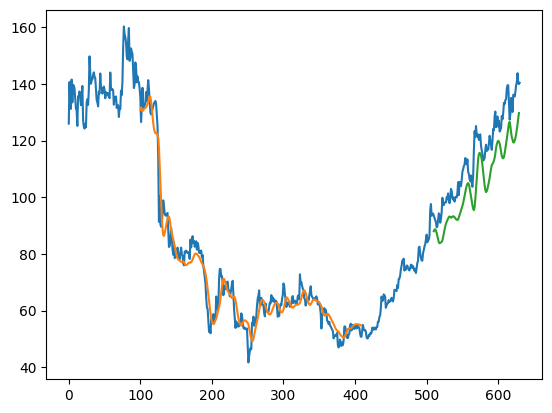

In [33]:
# Plotting
# Shift train predictions for plotting
look_back=100
train_predict_plot=np.empty_like(close_df)
train_predict_plot[:,:]=np.nan
train_predict_plot[look_back:len(train_predict)+look_back,:]=train_predict

# Shift test predictions for plotting
test_predict_plot=np.empty_like(close_df)
test_predict_plot[:,:]=np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1: len(close_df)-1,:]=test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(close_df))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [34]:
len(test_data)

221

In [35]:
x_input=test_data[121:].reshape(1,-1)
x_input.shape

(1, 100)

In [36]:
temp_input= list(x_input)
temp_input=temp_input[0].tolist()

In [37]:
temp_input

[0.4812473452907936,
 0.4740834346895624,
 0.4871470249713694,
 0.5166455497964977,
 0.5099030719772182,
 0.4917825327283394,
 0.48461862212710816,
 0.4909397345896357,
 0.4787188750213327,
 0.4909397345896357,
 0.4926253308670432,
 0.49136109994638766,
 0.5044247576533945,
 0.5364517527479836,
 0.4981036451908669,
 0.5372945593148373,
 0.5292877747215526,
 0.5246523343897823,
 0.5427728652105112,
 0.5676358822786693,
 0.5747997928799007,
 0.5844921821787427,
 0.588706257153761,
 0.6085123926800473,
 0.6030340867843735,
 0.5899704965025664,
 0.604298317705029,
 0.5667930841399657,
 0.5613147698161419,
 0.546144074621626,
 0.5394015968023465,
 0.5566792620591718,
 0.5347660806172265,
 0.5229666622590252,
 0.5554150901355661,
 0.6308470069039444,
 0.6881584518486434,
 0.6713021519485702,
 0.7037505208280614,
 0.6759375922803406,
 0.6713021519485702,
 0.6788874363347035,
 0.6624525692165819,
 0.6759375922803406,
 0.6788874363347035,
 0.6447534711778048,
 0.6308470069039444,
 0.62073325224

In [38]:
# demonstrate prediction for next 10 days 
output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        y_hat=model.predict(x_input,verbose=0)
        print("{} day output {}".format(i, y_hat))
        temp_input.extend(y_hat[0].tolist())
        temp_input=temp_input[1:]
        output.extend(y_hat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        y_hat=model.predict(x_input,verbose=0)
        print(y_hat[0])
        temp_input.extend(y_hat[0].tolist())
        print(len(temp_input))
        output.extend(y_hat.tolist())
        i=i+1
print(output)

[0.75615364]
101
1 day input [0.47408343 0.48714702 0.51664555 0.50990307 0.49178253 0.48461862
 0.49093973 0.47871888 0.49093973 0.49262533 0.4913611  0.50442476
 0.53645175 0.49810365 0.53729456 0.52928777 0.52465233 0.54277287
 0.56763588 0.57479979 0.58449218 0.58870626 0.60851239 0.60303409
 0.5899705  0.60429832 0.56679308 0.56131477 0.54614407 0.5394016
 0.55667926 0.53476608 0.52296666 0.55541509 0.63084701 0.68815845
 0.67130215 0.70375052 0.67593759 0.67130215 0.67888744 0.66245257
 0.67593759 0.67888744 0.64475347 0.63084701 0.62073325 0.60092705
 0.60345552 0.60809103 0.63168981 0.64812474 0.6291614  0.63843236
 0.63295404 0.65107458 0.67467336 0.6599241  0.64728187 0.63295404
 0.66034553 0.69532237 0.69068685 0.73240624 0.74673407 0.70037924
 0.72229242 0.73198481 0.70248628 0.71976401 0.68731559 0.69152966
 0.69827221 0.73367041 0.72397809 0.74251999 0.77243995 0.76864731
 0.7808681  0.78381788 0.81500213 0.82511589 0.82511589 0.77454699
 0.72271386 0.73999152 0.78718921 

In [39]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
day_new,day_pred

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130]))

In [40]:
len(close_df)

631

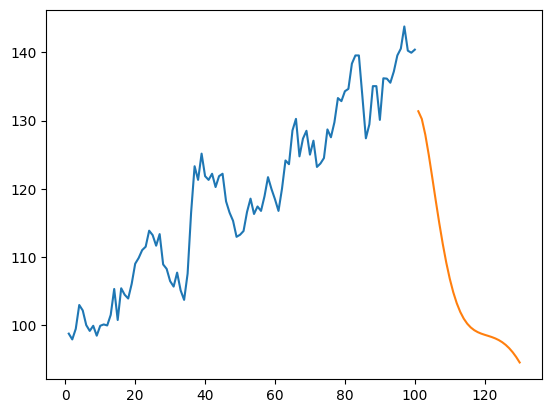

In [41]:
plt.plot(day_new,scaler.inverse_transform(close_df[531:]))
plt.plot(day_pred,scaler.inverse_transform(output))

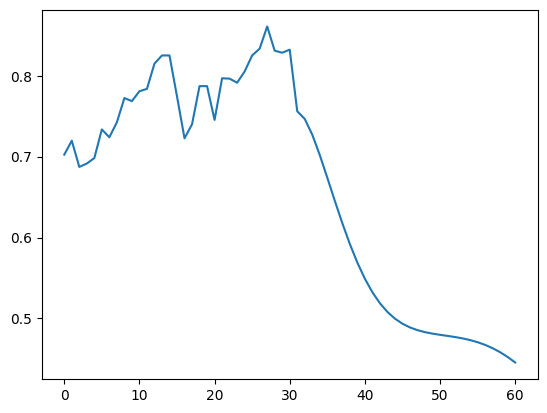

In [43]:
df2=close_df.tolist()
df2.extend(output)
plt.plot(df2[600:])

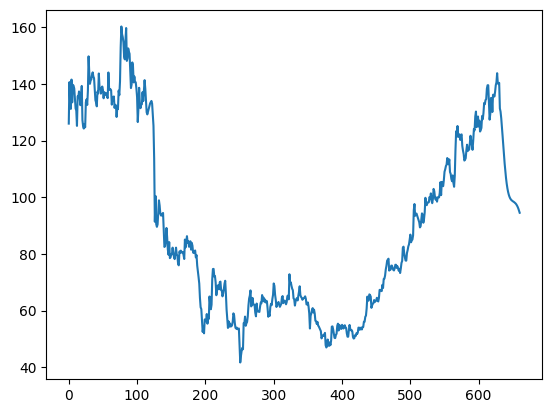

In [44]:
df2=scaler.inverse_transform(df2).tolist()
plt.plot(df2)